In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
# Load the dataset
df = pd.read_csv('C:/Users/a0095989/Desktop/important/Thesis/Model_Thesis/imputed_deu_data1.csv')

# Display the first few rows of the dataset
#print(df.head())

# Check for missing values
#print(df.isnull().sum())

# Basic statistics
#print(df.describe())

In [16]:
# Convert Year and Month into a single datetime feature
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

# Sort data by City and Date
df = df.sort_values(by=['City', 'Date'])

# Drop unnecessary columns (if any)
df = df.drop(columns=['Date'])  # Drop if not needed

# Check the preprocessed data
#print(df.head())

In [19]:
# Create a feature for the overall time trend (e.g., years since 1744)
df['YearsSince1744'] = df['Year'] - 1744

# Group data by City and Year, then calculate yearly average temperature
yearly_avg_temp = df.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

# Add the 'YearsSince1743' feature for each city
yearly_avg_temp['YearsSince1744'] = yearly_avg_temp['Year'] - 1744

# Check the new grouped data
#print(yearly_avg_temp.head())

In [20]:
# Normalize the data (LSTMs work better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(yearly_avg_temp[['YearsSince1744', 'AverageTemperature']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Features (all columns except the last one)
        y.append(data[i+seq_length, -1])     # Target (last column)
    return np.array(X), np.array(y)

# Define sequence length (e.g., 10 years)
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the splits
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (15302, 10, 1) (15302,)
Validation set: (3279, 10, 1) (3279,)
Test set: (3279, 10, 1) (3279,)


Epoch 1/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0706 - val_loss: 0.0161
Epoch 2/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 3/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0157 - val_loss: 0.0160
Epoch 4/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 5/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 6/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 7/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0154 - val_loss: 0.0162
Epoch 8/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0155 - val_loss: 0.0161
Epoch 9/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 10/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 11/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0153 - val_loss: 0.0162
Epoch 12/20
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

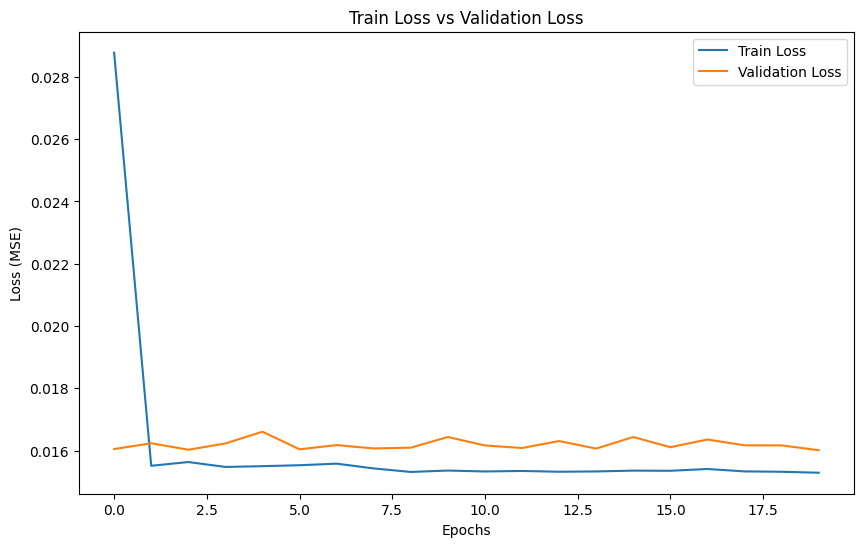

In [22]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

In [23]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Inverse transform the scaled predictions and actual values
y_val_pred_actual = scaler.inverse_transform(np.concatenate((X_val[:, -1, :], y_val_pred), axis=1))[:, -1]
y_val_actual = scaler.inverse_transform(np.concatenate((X_val[:, -1, :], y_val.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics
mae = mean_absolute_error(y_val_actual, y_val_pred_actual)
mse = mean_squared_error(y_val_actual, y_val_pred_actual)
r2 = r2_score(y_val_actual, y_val_pred_actual)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Absolute Error (MAE): 0.7490706732021278
Mean Squared Error (MSE): 1.0692802473206724
R-squared (R2): 0.11035489327546055


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


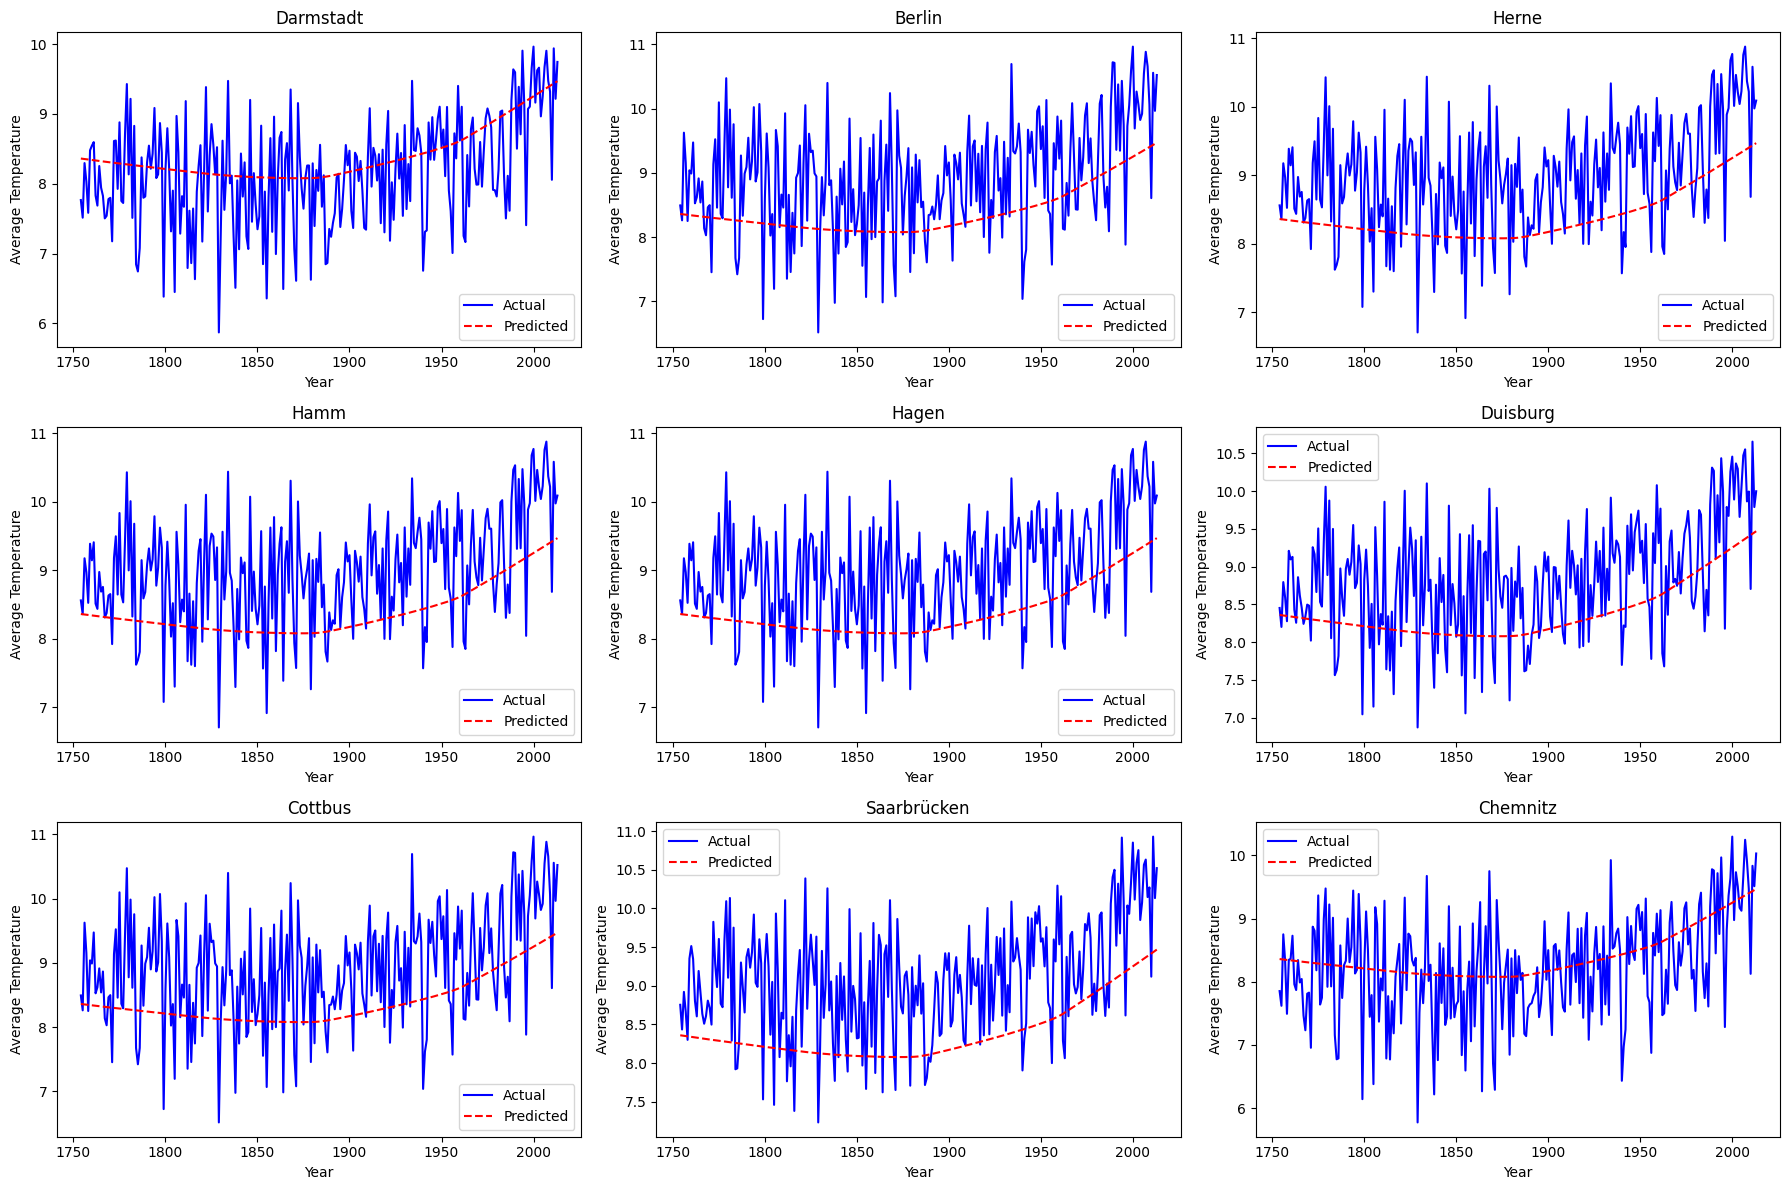

In [25]:
import random
# Select 9 random cities
random.seed(42)  # For reproducibility
selected_cities = random.sample(list(yearly_avg_temp['City'].unique()), 9)

# Create a 3x3 grid of subplots
plt.figure(figsize=(18, 12))
for i, city in enumerate(selected_cities, 1):
    plt.subplot(3, 3, i)
    
    # Filter data for the selected city
    city_data = yearly_avg_temp[yearly_avg_temp['City'] == city]
    scaled_city_data = scaler.transform(city_data[['YearsSince1744', 'AverageTemperature']])
    X_city, y_city = create_sequences(scaled_city_data, seq_length)
    
    # Make predictions
    y_city_pred = model.predict(X_city)
    y_city_pred_actual = scaler.inverse_transform(np.concatenate((X_city[:, -1, :], y_city_pred), axis=1))[:, -1]
    y_city_actual = scaler.inverse_transform(np.concatenate((X_city[:, -1, :], y_city.reshape(-1, 1)), axis=1))[:, -1]
    
    # Plot actual vs predicted values
    plt.plot(city_data['Year'][seq_length:], y_city_actual, label='Actual', color='blue')
    plt.plot(city_data['Year'][seq_length:], y_city_pred_actual, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.title(f'{city}')
    plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_test_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test_pred), axis=1))[:, -1]
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics for the test set
mae_test = mean_absolute_error(y_test_actual, y_test_pred_actual)
mse_test = mean_squared_error(y_test_actual, y_test_pred_actual)
r2_test = r2_score(y_test_actual, y_test_pred_actual)

# Print the metrics
print("Test Set Metrics:")
print("Mean Absolute Error (MAE):", mae_test)
print("Mean Squared Error (MSE):", mse_test)
print("R-squared (R2):", r2_test)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Set Metrics:
Mean Absolute Error (MAE): 0.7499678546554419
Mean Squared Error (MSE): 1.0111558527263969
R-squared (R2): 0.119738807294687


In [27]:
# Analyze the overall trend
if np.mean(y_test_pred_actual) > np.mean(y_test_actual):
    print("The model predicts a warming trend.")
else:
    print("The model predicts a cooling trend.")

The model predicts a cooling trend.
